* David Araujo Garcia 1671077
* Enric Ortega Barreda 1672973

# Introducció

* L'objectiu principal d'aquest treball és analitzar i processar una base de dades d'imatges extretes de tràilers de pel·lícules per a tasques de predicció de frames. La base de dades ha estat construïda consolidant frames de diverses pel·lícules, extrets directament dels seus tràilers.

# Recopilació de dades pel Dataset

* Per a aquest treball no hem utilitzat cap base de dades disponible a internet, sinó que n’hem creat una de pròpia. Per fer-ho, inicialment hem descarregat els tràilers de deu pel·lícules diferents. A partir d’aquests tràilers, hem extret 10 fragments de 5 segons per a cada pel·lícula i, posteriorment, hem generat els frames corresponents per tal de construir una base de dades amb un total de deu fragments per a cada pel·lícula.




Per automatitzar el procés i ser més eficients, hem desenvolupat un programa en Python que retalla automàticament cada tràiler en fragments de 5 segons. Aquesta eina ens ha permès processar tots els tràilers de manera ràpida i uniforme, assegurant que cada pel·lícula estigui representada amb fragments consistents.


In [1]:
from moviepy.video.io.VideoFileClip import VideoFileClip

def recortar_video_en_fragmentos(video_path, output_folder, duration=5):
    video = VideoFileClip(video_path)
    video_duration = video.duration  
    fragmentos = int(video_duration // duration)  
    
    for i in range(fragmentos):
        start_time = i * duration
        end_time = start_time + duration
        
        fragment = video.subclip(start_time, end_time)
        
        output_path = f"{output_folder}/fragmento_{i+1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")
    
    if video_duration % duration != 0:
        start_time = fragmentos * duration
        fragment = video.subclip(start_time, video_duration)
        output_path = f"{output_folder}/fragmento_{fragmentos + 1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")



Un cop retallat el tràiler en fragments de 5 segons, hem seleccionat aquells que millor s’adaptaven a les necessitats del nostre model. Hem prioritzat els fragments amb menys transicions abruptes, menys fosos a negre i escenes més uniformes. Aquest procés ens ha permès crear una base de dades més homogènia i optimitzada per garantir un millor rendiment durant l’entrenament del model.


Després de seleccionar els fragments més adequats per a cada pel·lícula, hem desenvolupat un programa per automatitzar el procés de conversió de vídeo a frames. L’objectiu és desglossar cada fragment seleccionat en imatges fixes que puguin ser utilitzades com a dades d’entrada per al model. 


In [2]:
import cv2
import os
from datetime import datetime

def video_to_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps}, Total Frames: {frame_count}")

    frame_num = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame_filename = os.path.join(output_folder, f"{timestamp}_frame_{frame_num:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_num += 1

    video.release()



Per enriquir el nostre dataset amb informació addicional sobre cada frame, hem calculat dues característiques visuals: **brillantor promig** i **contrast**. 

1. **Brillantor Promig**: Aquesta característica mesura la lluminositat general d’un frame. Es calcula convertint la imatge al format HSV i obtenint la mitjana del canal de valor (V), que representa la brillantor de cada píxel.

2. **Contrast**: Aquesta característica quantifica la diferència entre els píxels més foscos i més clars d’un frame. Es calcula com la diferència entre els valors màxim i mínim de la imatge en escala de grisos.

Amb aquestes dues característiques, podem analitzar la qualitat visual de cada frame i incloure informació rellevant que podria influir en el rendiment del model o ser útil en anàlisis posteriors.


In [13]:
import cv2
import numpy as np
import pandas as pd

def calcular_brillantor_promig(frame_path):
    frame = cv2.imread(frame_path)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    brillantor = np.mean(hsv[:, :, 2]) 
    return brillantor

def calcular_contrast(frame_path):
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) 
    contrast = np.max(frame) - np.min(frame)
    return contrast

Per tal de consolidar la informació de tots els frames en un únic dataset estructurat, hem creat una funció que automatitza el procés d'afegir dades de cada carpeta de frames al fitxer CSV definitiu. Aquesta funció, `agregar_carpeta_al_csv`, no només registra atributs bàsics com la ruta de cada imatge, el nom de la pel·lícula i el número de frame, sinó que també inclou característiques visuals com el **contrast** i la **brillantor promig** per enriquir el dataset.


In [25]:
import os
import csv

def agregar_carpeta_al_csv(carpeta_imagenes, archivo_csv, nombre_pelicula):
   
    with open(archivo_csv, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        if os.stat(archivo_csv).st_size == 0:
            writer.writerow(['ruta_imatge', 'pelicula', 'Nombre_frame','Contrast','Brillantor_promig'])  

        frame_numero = 1  
        for nombre_imagen in sorted(os.listdir(carpeta_imagenes)):
            ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)
            ruta_imagen = ruta_imagen.replace("\\", "/")

            
            if os.path.isfile(ruta_imagen) and nombre_imagen.lower().endswith(('.jpg')):
                frame_numero_formateado = "'" + str(frame_numero).zfill(4)
                Contraste=calcular_contrast(ruta_imagen)
                Brillo_promedio = calcular_brillantor_promig(ruta_imagen)
                writer.writerow([ruta_imagen, nombre_pelicula, frame_numero_formateado, Contraste, Brillo_promedio ])
                
                frame_numero += 1

    

Información de la carpeta './APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES' añadida al archivo CSV 'C:/Users/enric/APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_DATASET_FINAL.csv'


# 1. EDA (exploratory data analysis)

In [5]:
import os
os.chdir('C:/Users/enric')  # Cambia esto por la ruta base de tu compañero si estás compartiendo el script

In [1]:
import pandas as pd
path = "./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_DATASET_FINAL.csv"
df = pd.read_csv(path, encoding='latin1')

In [9]:
#Mirem el dataset
print(df.shape[1])
print (df.keys())
#Mirem els tipus de les columnes
print (df.dtypes)
#Mirem el tamany
print (df.size)

#Mirem descripcio general
print (df.describe())
df.head()

5
Index(['ruta_imatge', 'pelicula', 'Nombre_frame', 'Contrast',
       'Brillantor_promig'],
      dtype='object')
ruta_imatge           object
pelicula              object
Nombre_frame          object
Contrast               int64
Brillantor_promig    float64
dtype: object
59205
           Contrast  Brillantor_promig
count  11841.000000       11841.000000
mean     223.454522          69.232419
std       47.360101          39.197502
min        0.000000           0.000000
25%      216.000000          38.128139
50%      243.000000          65.548841
75%      253.000000          97.596820
max      255.000000         191.092712


,ruta_imatge,pelicula,Nombre_frame,Contrast,Brillantor_promig
0,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0001,186,57.048197
1,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0002,187,56.852338
2,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0003,187,55.830400
3,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0004,186,53.021832
4,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0005,187,48.718699


### Anàlisi Inicial del Dataset

Després d'una revisió inicial del dataset, podem destacar els següents punts rellevants:

1. **Dimensió i Columnes**:
   - El dataset conté un total de 5 columnes: `ruta_imatge`, `pelicula`, `Nombre_frame`, `Contrast`, i `Brillantor_promig`.
   - Té un total de 11.841 registres (frames), amb una mida total de 59.205 elements.


2. **Tipus de Dades**:
   - Les variables `ruta_imatge` i `pelicula` són de tipus `object`, adequades per emmagatzemar informació textual.
   - `Nombre_frame` és també de tipus `object` perquè conté un `'` (apòstrof) al començament de cada valor (per exemple, `'0001`). Això es va implementar per evitar que Excel convertís valors com `0001` a `1` automàticament.
   - Les variables numèriques, `Contrast` i `Brillantor_promig`, són de tipus `int64` i `float64`, respectivament.


In [12]:
# Dimensions del Dataset
num_frames = len(df)
num_pellicules = df['pelicula'].nunique()
print(f"Nombre de pel·lícules representades: {num_pellicules}")

# Distribució de Frames per Pel·lícula
distribucio_frames = df['pelicula'].value_counts()
print("Distribució de frames per pel·lícula:")
print(distribucio_frames)

Nombre de pel·lícules representades: 10
Distribució de frames per pel·lícula:
pelicula
THE_SHINNING        1500
CASABLANCA          1200
THE_GODFATHER_II    1200
GOODFELLAS          1200
SCARFACE            1200
BARBIE              1198
TORRENTE            1176
LA_LA_LAND          1152
APOCALYPSE_NOW      1126
THE_GODFATHER        889
Name: count, dtype: int64


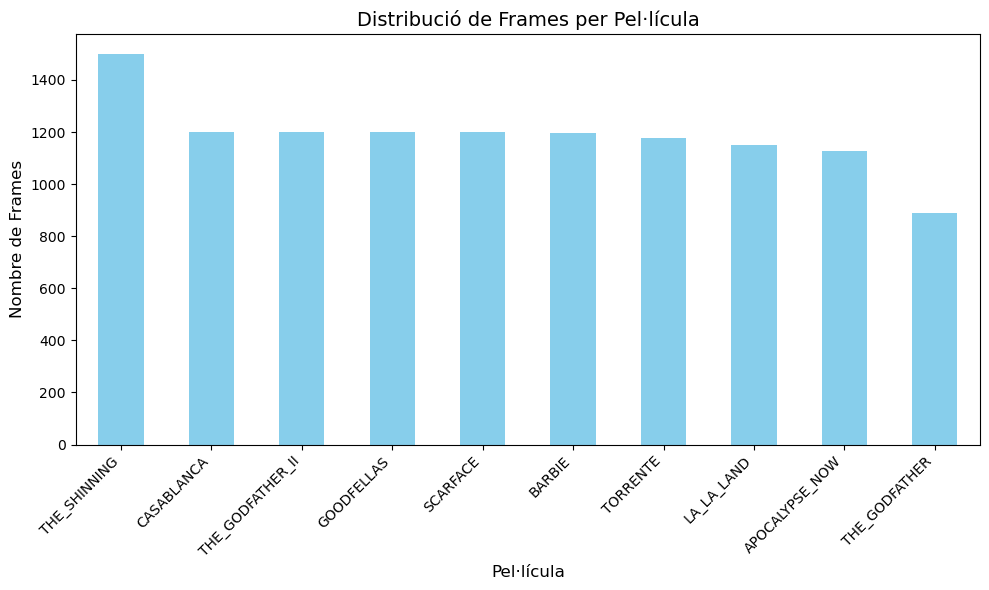

In [14]:
import matplotlib.pyplot as plt

# Gràfic de barres per la distribució
plt.figure(figsize=(10, 6))
distribucio_frames.plot(kind='bar', color='skyblue')
plt.title("Distribució de Frames per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de Frames", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


# 2. Preprocessing

### Tractament de Frames Negres com a Dades Nul·les

En aquest projecte, tot i que la base de dades no conté valors nuls tradicionals, hem identificat frames amb imatges totalment negres, generalment deguts a transicions entre escenes o fossos en negre. Tractarem aquestes imatges com a NaNs, ja que no aporten informació visual significativa per a l'anàlisi o l'entrenament del model. Aquest criteri ens permet gestionar de manera efectiva les dades menys útils dins del dataset.


In [17]:
from collections import Counter

# Detecció de NaNs
missing_values = []
count = 0
brillantor = df["Brillantor_promig"]
pelicula = df["pelicula"]

for i in range(len(brillantor)):
    if brillantor[i] <= 5:  # Considerem NaNs si el valor és <= 5
        count += 1
        missing_values.append(pelicula[i])

print("Tenim un total de", count, "NaNs")

# Comptar el nombre de NaNs per pel·lícula
compt = Counter(missing_values)

# Incloure totes les pel·lícules, encara que no tinguin NaNs
pelicules_totals = df['pelicula'].unique()
pelicules = list(pelicules_totals)
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]

# Mostrar resultats
print("Nombre de NaNs per pel·lícula:")
for pelicula, num in zip(pelicules, num_nans):
    print(f"{pelicula}: {num} NaNs")


Tenim un total de 192 NaNs
Nombre de NaNs per pel·lícula:
APOCALYPSE_NOW: 68 NaNs
BARBIE: 10 NaNs
CASABLANCA: 17 NaNs
THE_GODFATHER: 70 NaNs
THE_GODFATHER_II: 0 NaNs
GOODFELLAS: 0 NaNs
SCARFACE: 0 NaNs
THE_SHINNING: 16 NaNs
TORRENTE: 4 NaNs
LA_LA_LAND: 7 NaNs


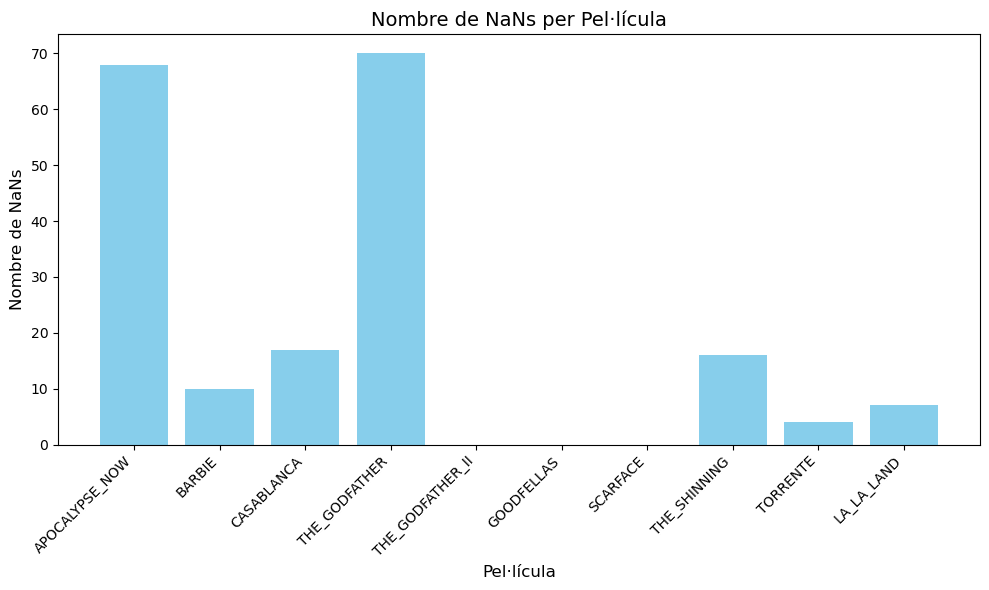

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Preparar les dades
pelicules_totals = df['pelicula'].unique()  # Llista completa de pel·lícules
pelicules = list(pelicules_totals)  # Convertir a llista
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]  # Comptar NaNs o assignar 0

# Generar el gràfic de barres
plt.figure(figsize=(10, 6))
plt.bar(pelicules, num_nans, color='skyblue')  # Utilitzem les dades de pel·lícules i NaNs
plt.title("Nombre de NaNs per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de NaNs", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.tight_layout()
plt.show()


Finalment, eliminem totes les instàncies de la base de dades que continguin valors considerats com a NaNs, ja que no aporten informació rellevant per al nostre estudi. A més, hem establert un llindar mínim per a la variable `Brillantor_promig`, de manera que qualsevol instància amb un valor per sota d'aquest llindar també serà eliminada definitivament. Aquesta depuració ens assegura que la base de dades resultant només inclou imatges significatives i adequades per al nostre objectiu d'anàlisi.

In [39]:
indexos_amb_NaNs=df[df["Brillantor_promig"]<=5].index
df=df.drop(indexos_amb_NaNs)
NaNs=(df["Brillantor_promig"]<=5).sum()
print(NaNs)

0


### Aplicació de LabelEncoder

Aplicarem **LabelEncoder** per transformar les següents variables categòriques en valors numèrics:
- **`pelicula`**: Per convertir els noms de les pel·lícules en valors numèrics que els models de machine learning puguin processar.


In [26]:
from sklearn.preprocessing import LabelEncoder


columnes_a_codificar = ['pelicula']  
label_encoders = {}  
for col in columnes_a_codificar:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  


print(df.head())

columna_original = 'pelicula'
print("Valors decodificats:", label_encoders[columna_original].inverse_transform(df[columna_original][:5]))


                                         ruta_imatge  pelicula Nombre_frame  \
0  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0001   
1  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0002   
2  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0003   
3  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0004   
4  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0005   

   Contrast  Brillantor_promig  
0       186          57.048197  
1       187          56.852338  
2       187          55.830400  
3       186          53.021832  
4       187          48.718699  
Valors decodificats: ['APOCALYPSE_NOW' 'APOCALYPSE_NOW' 'APOCALYPSE_NOW' 'APOCALYPSE_NOW'
 'APOCALYPSE_NOW']


### Normalization
Per tal de garantir la coherència i facilitar l'anàlisi, hem aplicat processos de normalització a diferents aspectes de les dades:

1. **Mida de les imatges**:
   - Tots els frames han estat redimensionats a una mida comuna i única. Aquesta uniformitat és essencial per treballar amb xarxes neuronals o altres tècniques d'anàlisi d'imatges que requereixen inputs de dimensions fixes.


In [47]:
import cv2
import os

def redimensionar_imagenes(df, nuevo_tamano=(1024, 1024)):
    
    for index,row in df.iterrows():
        ruta = row['ruta_imatge'] 
        
        try:
        
            img = cv2.imread(ruta)
            if img is not None:
                
                img_redimensionada = cv2.resize(img, nuevo_tamano, interpolation=cv2.INTER_AREA)
                
                cv2.imwrite(ruta, img_redimensionada)
            else:
                print(f"No s'ha pogut llegir la imatge: {ruta}")
        except Exception as e:
            print(f"Error al procesar la imatge {ruta}: {e}")
    return df
df=redimensionar_imagenes(df, nuevo_tamano=(1024, 1024))

In [34]:
import cv2

def comprobar_tamano_imagenes(rutas_imagenes):
    tamanos = {}
    
    for ruta in rutas_imagenes:

        img = cv2.imread(ruta)
        if img is not None:
            altura, anchura = img.shape[:2]
            tamano = (anchura, altura)

            if tamano in tamanos:
                tamanos[tamano] += 1
            else:
                tamanos[tamano] = 1
        else:
            print(f"No s'ha pogut llegir la imatge: {ruta}")
    
    return tamanos


rutas = df['ruta_imatge'].tolist()
tamanos_imagenes = comprobar_tamano_imagenes(rutas)


print("Tamany de les imatges i la seva freqüència:")
for tamano, frecuencia in tamanos_imagenes.items():
    print(f"Tamany {tamano}: {frecuencia} imatges")

Tamaños de las imágenes y su frecuencia:
Tamaño (1024, 1024): 11649 imágenes


2. **Variables `Brillantor_promig` i `Contrast`**:
   - Aquestes variables han estat normalitzades per portar-les a escales comparables. Això permet que aquestes característiques contribueixin de manera equilibrada durant l'entrenament del model i evita que cap d'elles tingui un pes excessiu en els resultats.


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Brillantor_promig', 'Contrast']] = scaler.fit_transform(df[['Brillantor_promig', 'Contrast']])


### Aleatorització del dataset abans de la divisió

* Abans de dividir el dataset en els conjunts de **train**, **validation** i **test**, és una bona pràctica aleatoritzar les dades per garantir que les classes i les característiques estiguin distribuïdes uniformement entre els subconjunts. 

In [50]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# 3. IMAGE PROCESSING (Bag of Visual Words)

* Per garantir un bon aprenentatge del model, hem optat per utilitzar l'algoritme de **Bag of Visual Words (BoVW)** en el nostre projecte. Aquest enfocament ens permet extreure característiques comunes dels frames, que posteriorment transformem en histogrames. Aquests histogrames ajuden a entrenar el model de manera eficient, millorant així la seva capacitat per predir amb la millor precisió possible.



### Selecció dels frames

* En aquesta primera part del projecte, el nostre objectiu és que el model sigui capaç de predir la pel·lícula a la qual pertany un frame donat. Com que disposem d'uns 1200 frames per cada pel·lícula, el cost computacional de generar els descriptors és elevat (hores d'execució). Per optimitzar aquest procés, hem seleccionat aleatòriament **300 frames** de cada pel·lícula mitjançant un programa, amb l'objectiu de facilitar l'entrenament del model i aconseguir la predicció correcta de la pel·lícula.


In [294]:
import pandas as pd

def seleccionar_frames_por_pelicula(df, num_frames=300):
    frames_seleccionados = pd.DataFrame()

    for pelicula, grupo in df.groupby('pelicula'):
        if len(grupo) > num_frames:
        
            frames_reducidos = grupo.sample(n=num_frames, random_state=42)
        else:

            frames_reducidos = grupo

        frames_seleccionados = pd.concat([frames_seleccionados, frames_reducidos], ignore_index=True)

    return frames_seleccionados
    
df_reducido = seleccionar_frames_por_pelicula(df, num_frames=300)
df_reducido.to_csv('frames_reducidos.csv', index=False)
ruta_imagenes = df_reducido['ruta_imatge'].tolist()

### Descriptors

* Un cop hem seleccionat els frames, el següent pas és extreure les característiques més rellevants de cadascun d'aquests, és a dir, els descriptors. Per a això, hem utilitzat l'algoritme **SIFT (Scale-Invariant Feature Transform)**. Com que l'execució d'aquest procés és molt lenta, hem decidit guardar els descriptors generats a l'ordinador per evitar haver de repetir el càlcul en cada execució del programa.

In [296]:
import cv2
import os
import numpy as np

def extraer_caracteristicas_sift(ruta_imagenes):

    sift = cv2.SIFT_create()
    
    descriptores_totales = []
    keypoints_totales = []

    for ruta in ruta_imagenes:
        imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
        if imagen is None:
            print(f"No s'ha pogut llegir la imatge: {ruta}")
            continue
        
        # Detectar keypoints y calcular descriptores
        keypoints, descriptores = sift.detectAndCompute(imagen, None)
        if descriptores is not None:
            descriptores_totales.append(descriptores)
            keypoints_totales.append(keypoints)
        
        print(f"Processada la imatge: {ruta}, Keypoints detectats: {len(keypoints)}")
    
    return descriptores_totales, keypoints_totales


descriptores, keypoints = extraer_caracteristicas_sift(ruta_imagenes)
np.savez('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/descriptores_sift.npz', *descriptores)


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0070.jpg, Keypoints detectados: 2119
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0106.jpg, Keypoints detectados: 3640
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0056.jpg, Keypoints detectados: 713
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0031.jpg, Keypoints detectados: 535
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0041.jpg, Keypoints detectados: 2231
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0097.jpg, Keypoints detectados: 430
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0070.jpg, Keypoints detectados: 2929
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0087.jpg, Keypoints detectados: 71
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0039.jpg, Keypoints detectados: 3461
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0115.jpg, Keypoints detectados: 3207
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0041.jpg, Keypoints detectados: 1696
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0025.jpg, Keypoints detectados: 1384
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0022.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0083.jpg, Keypoints detectados: 1081
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0052.jpg, Keypoints detectados: 98
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0103.jpg, Keypoints detectados: 1828
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0045.jpg, Keypoints detectados: 451
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0033.jpg, Keypoints detectados: 89
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0006.jpg, Keypoints detectados: 64
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0040.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0077.jpg, Keypoints detectados: 1716
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0063.jpg, Keypoints detectados: 500
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0094.jpg, Keypoints detectados: 449
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0010.jpg, Keypoints detectados: 228
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0005.jpg, Keypoints detectados: 84
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0057.jpg, Keypoints detectados: 15
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0017.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0045.jpg, Keypoints detectados: 6166
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0104.jpg, Keypoints detectados: 1050
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101225_frame_0007.jpg, Keypoints detectados: 25
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0048.jpg, Keypoints detectados: 1016
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0079.jpg, Keypoints detectados: 14
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0123.jpg, Keypoints detectados: 178
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0012.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0019.jpg, Keypoints detectados: 86
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0057.jpg, Keypoints detectados: 251
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0006.jpg, Keypoints detectados: 2372
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0011.jpg, Keypoints detectados: 25
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0017.jpg, Keypoints detectados: 142
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0001.jpg, Keypoints detectados: 1214
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0002.jpg, Keypoints detectados: 7

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0030.jpg, Keypoints detectados: 355
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0115.jpg, Keypoints detectados: 1523
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0090.jpg, Keypoints detectados: 868
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0040.jpg, Keypoints detectados: 3216
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0100.jpg, Keypoints detectados: 2799
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0029.jpg, Keypoints detectados: 1249
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0103.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0033.jpg, Keypoints detectados: 1608
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0118.jpg, Keypoints detectados: 50
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0046.jpg, Keypoints detectados: 547
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0030.jpg, Keypoints detectados: 512
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0094.jpg, Keypoints detectados: 10
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101225_frame_0107.jpg, Keypoints detectados: 108
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0060.jpg, 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0073.jpg, Keypoints detectados: 1913
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0089.jpg, Keypoints detectados: 1946
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0009.jpg, Keypoints detectados: 1679
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0076.jpg, Keypoints detectados: 1323
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0010.jpg, Keypoints detectados: 405
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0032.jpg, Keypoints detectados: 3226
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0029.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0037.jpg, Keypoints detectados: 696
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0004.jpg, Keypoints detectados: 726
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0082.jpg, Keypoints detectados: 963
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0139.jpg, Keypoints detectados: 2685
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0023.jpg, Keypoints detectados: 1633
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0004.jpg, Keypoints detectados: 3698
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0033.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0010.jpg, Keypoints detectados: 218
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0013.jpg, Keypoints detectados: 102
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0079.jpg, Keypoints detectados: 397
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0090.jpg, Keypoints detectados: 1704
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0009.jpg, Keypoints detectados: 331
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0109.jpg, Keypoints detectados: 396
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0050.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0038.jpg, Keypoints detectados: 613
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0132.jpg, Keypoints detectados: 2708
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0040.jpg, Keypoints detectados: 165
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0066.jpg, Keypoints detectados: 323
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0097.jpg, Keypoints detectados: 753
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0029.jpg, Keypoints detectados: 533
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0070.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0016.jpg, Keypoints detectados: 208
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0089.jpg, Keypoints detectados: 2797
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0049.jpg, Keypoints detectados: 415
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0007.jpg, Keypoints detectados: 3651
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0014.jpg, Keypoints detectados: 471
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0079.jpg, Keypoints detectados: 9166
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0097.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0099.jpg, Keypoints detectados: 188
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0093.jpg, Keypoints detectados: 722
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0065.jpg, Keypoints detectados: 3766
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0114.jpg, Keypoints detectados: 272
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0028.jpg, Keypoints detectados: 2042
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0052.jpg, Keypoints detectados: 204
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0042.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0039.jpg, Keypoints detectados: 2575
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0117.jpg, Keypoints detectados: 585
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0044.jpg, Keypoints detectados: 2208
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0087.jpg, Keypoints detectados: 29
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0003.jpg, Keypoints detectados: 1196
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0048.jpg, Keypoints detectados: 576
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0039.jpg, Keypoint

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0053.jpg, Keypoints detectados: 174
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0146.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0086.jpg, Keypoints detectados: 66
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0084.jpg, Keypoints detectados: 1969
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0119.jpg, Keypoints detectados: 1698
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0065.jpg, Keypoints detectados: 124
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0047.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0062.jpg, Keypoints detectados: 2269
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0029.jpg, Keypoints detectados: 643
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0016.jpg, Keypoints detectados: 279
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0089.jpg, Keypoints detectados: 76
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0101.jpg, Keypoints detectados: 2825
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0111.jpg, Keypoints detectados: 126
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0025.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0110.jpg, Keypoints detectados: 1026
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0059.jpg, Keypoints detectados: 587
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0058.jpg, Keypoints detectados: 182
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0021.jpg, Keypoints detectados: 53
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0050.jpg, Keypoints detectados: 802
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0113.jpg, Keypoints detectados: 69
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0045.jpg, Keypoi

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0047.jpg, Keypoints detectados: 2753
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0014.jpg, Keypoints detectados: 4520
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0029.jpg, Keypoints detectados: 50
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0023.jpg, Keypoints detectados: 465
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0111.jpg, Keypoints detectados: 47
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0094.jpg, Keypoints detectados: 718
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0110.jpg, Keypoin

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0045.jpg, Keypoints detectados: 2002
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0054.jpg, Keypoints detectados: 164
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0022.jpg, Keypoints detectados: 3311
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0131.jpg, Keypoints detectados: 968
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0008.jpg, Keypoints detectados: 165
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0021.jpg, Keypoints detectados: 5721
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0096.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0040.jpg, Keypoints detectados: 853
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0057.jpg, Keypoints detectados: 2796
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0092.jpg, Keypoints detectados: 1621
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0082.jpg, Keypoints detectados: 3453
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0033.jpg, Keypoints detectados: 1611
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0000.jpg, Keypoints detectados: 1763
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0014.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0100.jpg, Keypoints detectados: 792
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0039.jpg, Keypoints detectados: 1731
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0067.jpg, Keypoints detectados: 556
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0072.jpg, Keypoints detectados: 752
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0094.jpg, Keypoints detectados: 2350
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0115.jpg, Keypoints detectados: 228
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0082.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0039.jpg, Keypoints detectados: 80
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0061.jpg, Keypoints detectados: 63
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0076.jpg, Keypoints detectados: 730
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0049.jpg, Keypoints detectados: 511
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0075.jpg, Keypoints detectados: 350
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0048.jpg, Keypoints detectados: 3450
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0047.jpg, Keypoin

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0002.jpg, Keypoints detectados: 1901
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0067.jpg, Keypoints detectados: 2181
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0022.jpg, Keypoints detectados: 145
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0094.jpg, Keypoints detectados: 558
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0078.jpg, Keypoints detectados: 1931
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0024.jpg, Keypoints detectados: 182
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0112.jpg, Keyp

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0039.jpg, Keypoints detectados: 323
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0116.jpg, Keypoints detectados: 278
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0007.jpg, Keypoints detectados: 162
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0031.jpg, Keypoints detectados: 198
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0068.jpg, Keypoints detectados: 1422
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0030.jpg, Keypoints detectados: 464
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0079.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0063.jpg, Keypoints detectados: 1698
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0012.jpg, Keypoints detectados: 367
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0004.jpg, Keypoints detectados: 663
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0054.jpg, Keypoints detectados: 264
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0114.jpg, Keypoints detectados: 70
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0117.jpg, Keypoints detectados: 3604
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0088.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0022.jpg, Keypoints detectados: 3542
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0115.jpg, Keypoints detectados: 491
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0034.jpg, Keypoints detectados: 76
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0026.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0108.jpg, Keypoints detectados: 613
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0075.jpg, Keypoints detectados: 831
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0021.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0023.jpg, Keypoints detectados: 28
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0115.jpg, Keypoints detectados: 431
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0103.jpg, Keypoints detectados: 176
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0044.jpg, Keypoints detectados: 2592
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0098.jpg, Keypoints detectados: 967
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0100.jpg, Keypoints detectados: 5230
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0085.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0001.jpg, Keypoints detectados: 4434
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0104.jpg, Keypoints detectados: 1389
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0075.jpg, Keypoints detectados: 1987
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0059.jpg, Keypoints detectados: 635
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0013.jpg, Keypoints detectados: 1709
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0051.jpg, Keypoints detectados: 164
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0061.jpg, 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0093.jpg, Keypoints detectados: 1307
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0033.jpg, Keypoints detectados: 201
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0092.jpg, Keypoints detectados: 1313
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0115.jpg, Keypoints detectados: 218
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0023.jpg, Keypoints detectados: 106
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0085.jpg, Keypoints detectados: 191
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0013.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0019.jpg, Keypoints detectados: 608
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0021.jpg, Keypoints detectados: 2107
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0061.jpg, Keypoints detectados: 183
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0077.jpg, Keypoints detectados: 522
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0034.jpg, Keypoints detectados: 922
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0105.jpg, Keypoints detectados: 357
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0029.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0012.jpg, Keypoints detectados: 1836
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0071.jpg, Keypoints detectados: 231
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0000.jpg, Keypoints detectados: 5
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0046.jpg, Keypoints detectados: 1025
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0104.jpg, Keypoints detectados: 2824
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0065.jpg, Keypoints detectados: 2684
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0057.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0004.jpg, Keypoints detectados: 2921
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0114.jpg, Keypoints detectados: 373
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0076.jpg, Keypoints detectados: 2623
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0035.jpg, Keypoints detectados: 215
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0088.jpg, Keypoints detectados: 1659
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0103.jpg, Keypoints detectados: 417
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0134.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0043.jpg, Keypoints detectados: 6170
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0097.jpg, Keypoints detectados: 47
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0081.jpg, Keypoints detectados: 113
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0007.jpg, Keypoints detectados: 2249
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0080.jpg, Keypoints detectados: 73
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0051.jpg, Keypoints detectados: 1167
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0079.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0058.jpg, Keypoints detectados: 833
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0023.jpg, Keypoints detectados: 161
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0055.jpg, Keypoints detectados: 701
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0040.jpg, Keypoints detectados: 451
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0133.jpg, Keypoints detectados: 2712
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0084.jpg, Keypoints detectados: 75
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0077.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0045.jpg, Keypoints detectados: 573
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0028.jpg, Keypoints detectados: 316
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0096.jpg, Keypoints detectados: 487
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0052.jpg, Keypoints detectados: 479
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0024.jpg, Keypoints detectados: 2276
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0050.jpg, Keypoints detectados: 844
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0093.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0052.jpg, Keypoints detectados: 557
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0094.jpg, Keypoints detectados: 282
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0050.jpg, Keypoints detectados: 892
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0052.jpg, Keypoints detectados: 260
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0051.jpg, Keypoints detectados: 585
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0102.jpg, Keypoints detectados: 617
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0075.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0000.jpg, Keypoints detectados: 56
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0105.jpg, Keypoints detectados: 3973
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0003.jpg, Keypoints detectados: 20
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0050.jpg, Keypoints detectados: 2996
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0060.jpg, Keypoints detectados: 11
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0051.jpg, Keypoints detectados: 272
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0093.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0042.jpg, Keypoints detectados: 333
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0061.jpg, Keypoints detectados: 323
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0076.jpg, Keypoints detectados: 3091
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0060.jpg, Keypoints detectados: 200
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0057.jpg, Keypoints detectados: 35
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0004.jpg, Keypoints detectados: 1432
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0011.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0060.jpg, Keypoints detectados: 62
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0046.jpg, Keypoints detectados: 317
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0008.jpg, Keypoints detectados: 175
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0055.jpg, Keypoints detectados: 937
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0089.jpg, Keypoints detectados: 2078
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0126.jpg, Keypoints detectados: 968
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0085.jpg, Keypoints detectados: 62

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0073.jpg, Keypoints detectados: 1935
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0104.jpg, Keypoints detectados: 266
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0102.jpg, Keypoints detectados: 1410
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0088.jpg, Keypoints detectados: 324
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0063.jpg, Keypoints detectados: 904
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0029.jpg, Keypoints detectados: 352
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0078.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0106.jpg, Keypoints detectados: 888
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0083.jpg, Keypoints detectados: 590
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0082.jpg, Keypoints detectados: 492
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0092.jpg, Keypoints detectados: 5753
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0118.jpg, Keypoints detectados: 177
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0060.jpg, Keypoints detectados: 986
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0110.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0114.jpg, Keypoints detectados: 1430
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0092.jpg, Keypoints detectados: 8
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0108.jpg, Keypoints detectados: 176
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0080.jpg, Keypoints detectados: 1153
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0072.jpg, Keypoints detectados: 982
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0037.jpg, Keypoints detectados: 2236
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0055.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0003.jpg, Keypoints detectados: 1760
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0114.jpg, Keypoints detectados: 839
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0026.jpg, Keypoints detectados: 72
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0034.jpg, Keypoints detectados: 1972
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0105.jpg, Keypoints detectados: 1740
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0127.jpg, Keypoints detectados: 253
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0098.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0004.jpg, Keypoints detectados: 3666
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0104.jpg, Keypoints detectados: 1693
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0078.jpg, Keypoints detectados: 77
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0004.jpg, Keypoints detectados: 3263
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0106.jpg, Keypoints detectados: 1235
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0070.jpg, Keypoints detectados: 2680
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0086.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0081.jpg, Keypoints detectados: 1786
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0041.jpg, Keypoints detectados: 74
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0032.jpg, Keypoints detectados: 463
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0110.jpg, Keypoints detectados: 356
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0109.jpg, Keypoints detectados: 12
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0079.jpg, Keypoints detectados: 618
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0045.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0091.jpg, Keypoints detectados: 1803
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0040.jpg, Keypoints detectados: 3004
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0088.jpg, Keypoints detectados: 207
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0058.jpg, Keypoints detectados: 149
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0101.jpg, Keypoints detectados: 77
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0092.jpg, Keypoints detectados: 135
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0075.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0037.jpg, Keypoints detectados: 5747
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0031.jpg, Keypoints detectados: 3222
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0062.jpg, Keypoints detectados: 159
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0001.jpg, Keypoints detectados: 1858
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0093.jpg, Keypoints detectados: 940
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0012.jpg, Keypoints detectados: 6039
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0117.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0119.jpg, Keypoints detectados: 683
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0103.jpg, Keypoints detectados: 1220
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0034.jpg, Keypoints detectados: 3171
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0016.jpg, Keypoints detectados: 6
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0054.jpg, Keypoints detectados: 1780
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0004.jpg, Keypoints detectados: 1907
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0076.jpg, Keypoint

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0024.jpg, Keypoints detectados: 36
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0057.jpg, Keypoints detectados: 292
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0096.jpg, Keypoints detectados: 62
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0007.jpg, Keypoints detectados: 458
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0105.jpg, Keypoints detectados: 38
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0038.jpg, Keypoints detectados: 937
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0000.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0046.jpg, Keypoints detectados: 315
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0044.jpg, Keypoints detectados: 6208
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0053.jpg, Keypoints detectados: 173
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0015.jpg, Keypoints detectados: 1609
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0116.jpg, Keypoints detectados: 72
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0109.jpg, Keypoints detectados: 6127
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0025.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0052.jpg, Keypoints detectados: 2466
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0026.jpg, Keypoints detectados: 196
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0010.jpg, Keypoints detectados: 2465
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0078.jpg, Keypoints detectados: 9153
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0112.jpg, Keypoints detectados: 191
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0050.jpg, Keypoints detectados: 425
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0090.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0061.jpg, Keypoints detectados: 2879
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0043.jpg, Keypoints detectados: 108
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0008.jpg, Keypoints detectados: 612
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0108.jpg, Keypoints detectados: 61
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0075.jpg, Keypoints detectados: 454
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0014.jpg, Keypoints detectados: 399
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0040.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0024.jpg, Keypoints detectados: 2385
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0063.jpg, Keypoints detectados: 37
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0099.jpg, Keypoints detectados: 1775
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0008.jpg, Keypoints detectados: 6
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0106.jpg, Keypoints detectados: 871
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0066.jpg, Keypoints detectados: 2439
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0091.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0060.jpg, Keypoints detectados: 109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0050.jpg, Keypoints detectados: 170
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0053.jpg, Keypoints detectados: 298
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0055.jpg, Keypoints detectados: 165
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0022.jpg, Keypoints detectados: 3090
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0059.jpg, Keypoints detectados: 935
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0116.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0105.jpg, Keypoints detectados: 80
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0032.jpg, Keypoints detectados: 1662
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0133.jpg, Keypoints detectados: 346
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0147.jpg, Keypoints detectados: 3260
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0085.jpg, Keypoints detectados: 782
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0053.jpg, Keypoints detectados: 425
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0108.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0079.jpg, Keypoints detectados: 922
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0100.jpg, Keypoints detectados: 588
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0104.jpg, Keypoints detectados: 2443
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0050.jpg, Keypoints detectados: 174
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0099.jpg, Keypoints detectados: 1313
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0015.jpg, Keypoints detectados: 3069
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0006.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0037.jpg, Keypoints detectados: 710
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0107.jpg, Keypoints detectados: 83
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0082.jpg, Keypoints detectados: 76
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0052.jpg, Keypoints detectados: 847
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0064.jpg, Keypoints detectados: 1725
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0041.jpg, Keypoints detectados: 1112
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0116.jpg, Keypoints detectados: 1144

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0089.jpg, Keypoints detectados: 365
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0047.jpg, Keypoints detectados: 331
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0037.jpg, Keypoints detectados: 1323
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0013.jpg, Keypoints detectados: 663
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0130.jpg, Keypoints detectados: 3153
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0105.jpg, Keypoints detectados: 1823
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0056.jpg, Keypoin

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0056.jpg, Keypoints detectados: 347
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0052.jpg, Keypoints detectados: 2604
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0044.jpg, Keypoints detectados: 1179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0047.jpg, Keypoints detectados: 2982
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0082.jpg, Keypoints detectados: 1904
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0028.jpg, Keypoints detectados: 388
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0071.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0118.jpg, Keypoints detectados: 179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0059.jpg, Keypoints detectados: 707
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0062.jpg, Keypoints detectados: 782
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0018.jpg, Keypoints detectados: 2742
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0077.jpg, Keypoints detectados: 748
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0059.jpg, Keypoints detectados: 3103
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0069.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0101.jpg, Keypoints detectados: 238
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123148frame0098.jpg, Keypoints detectados: 115
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0109.jpg, Keypoints detectados: 2714
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0045.jpg, Keypoints detectados: 1296
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0081.jpg, Keypoints detectados: 873
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0113.jpg, Keypoints detectados: 841
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0065.jpg, Keypoints detectados: 3589
P

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0059.jpg, Keypoints detectados: 646
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0012.jpg, Keypoints detectados: 4695
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0072.jpg, Keypoints detectados: 2322
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0117.jpg, Keypoints detectados: 411
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0100.jpg, Keypoints detectados: 184
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0115.jpg, Keypoints detectados: 1013
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0011.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0005.jpg, Keypoints detectados: 329
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0035.jpg, Keypoints detectados: 2143
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0059.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0088.jpg, Keypoints detectados: 130
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0045.jpg, Keypoints detectados: 1659
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0019.jpg, Keypoints detectados: 115
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0012.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0056.jpg, Keypoints detectados: 1467
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0012.jpg, Keypoints detectados: 1999
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0009.jpg, Keypoints detectados: 2091
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0034.jpg, Keypoints detectados: 2393
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0113.jpg, Keypoints detectados: 524
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0111.jpg, Keypoints detectados: 590
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0092.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0106.jpg, Keypoints detectados: 249
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0111.jpg, Keypoints detectados: 1107
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0040.jpg, Keypoints detectados: 1389
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0020.jpg, Keypoints detectados: 3132
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0019.jpg, Keypoints detectados: 36
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0014.jpg, Keypoints detectados: 589
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0072.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0016.jpg, Keypoints detectados: 2058
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0119.jpg, Keypoints detectados: 86
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0059.jpg, Keypoints detectados: 344
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0102.jpg, Keypoints detectados: 388
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0075.jpg, Keypoints detectados: 1064
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0055.jpg, Keypoints detectados: 313
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0071.jpg, Keypoint

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0010.jpg, Keypoints detectados: 44
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0108.jpg, Keypoints detectados: 6520
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0006.jpg, Keypoints detectados: 4429
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0089.jpg, Keypoints detectados: 175
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0053.jpg, Keypoints detectados: 473
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0038.jpg, Keypoints detectados: 75
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0031.jpg, Keypoint

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0083.jpg, Keypoints detectados: 1101
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0040.jpg, Keypoints detectados: 3190
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0110.jpg, Keypoints detectados: 2720
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0027.jpg, Keypoints detectados: 2169
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0029.jpg, Keypoints detectados: 67
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0048.jpg, Keypoints detectados: 699
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0110.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0092.jpg, Keypoints detectados: 41
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0098.jpg, Keypoints detectados: 1693
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0037.jpg, Keypoints detectados: 81
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0041.jpg, Keypoints detectados: 839
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0026.jpg, Keypoints detectados: 263
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0022.jpg, Keypoints detectados: 2233
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0002.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0085.jpg, Keypoints detectados: 110
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0022.jpg, Keypoints detectados: 1457
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0031.jpg, Keypoints detectados: 2308
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0103.jpg, Keypoints detectados: 3158
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0079.jpg, Keypoints detectados: 47
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0081.jpg, Keypoints detectados: 1001
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0104.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0129.jpg, Keypoints detectados: 2710
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0031.jpg, Keypoints detectados: 911
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0090.jpg, Keypoints detectados: 1557
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0005.jpg, Keypoints detectados: 167
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0111.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0016.jpg, Keypoints detectados: 1718
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0119.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0041.jpg, Keypoints detectados: 2820
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0028.jpg, Keypoints detectados: 4139
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0073.jpg, Keypoints detectados: 73
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0109.jpg, Keypoints detectados: 118
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0112.jpg, Keypoints detectados: 1489
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0068.jpg, Keypoints detectados: 3401
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0136.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0097.jpg, Keypoints detectados: 1383
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0002.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0034.jpg, Keypoints detectados: 433
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0033.jpg, Keypoints detectados: 409
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0103.jpg, Keypoints detectados: 1461
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0013.jpg, Keypoints detectados: 822
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0027.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0027.jpg, Keypoints detectados: 815
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0119.jpg, Keypoints detectados: 387
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0093.jpg, Keypoints detectados: 2684
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0000.jpg, Keypoints detectados: 718
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0002.jpg, Keypoints detectados: 3200
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0075.jpg, Keypoints detectados: 179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0002.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0086.jpg, Keypoints detectados: 3024
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0094.jpg, Keypoints detectados: 110
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0080.jpg, Keypoints detectados: 552
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0057.jpg, Keypoints detectados: 3597
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0072.jpg, Keypoints detectados: 320
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0110.jpg, Keypoints detectados: 3652
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0013.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0026.jpg, Keypoints detectados: 484
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0106.jpg, Keypoints detectados: 2402
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0067.jpg, Keypoints detectados: 8062
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0114.jpg, Keypoints detectados: 497
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0112.jpg, Keypoints detectados: 29
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0005.jpg, Keypoints detectados: 3133
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0047.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0043.jpg, Keypoints detectados: 2674
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0076.jpg, Keypoints detectados: 1881
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0083.jpg, Keypoints detectados: 548
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0116.jpg, Keypoints detectados: 163
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0009.jpg, Keypoints detectados: 1853
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0010.jpg, Keypoints detectados: 56
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0138.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0014.jpg, Keypoints detectados: 3492
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0038.jpg, Keypoints detectados: 417
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0082.jpg, Keypoints detectados: 783
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0038.jpg, Keypoints detectados: 1718
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0012.jpg, Keypoints detectados: 1474
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0004.jpg, Keypoints detectados: 1780
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0001.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0016.jpg, Keypoints detectados: 529
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0077.jpg, Keypoints detectados: 176
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0103.jpg, Keypoints detectados: 1045
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0063.jpg, Keypoints detectados: 156
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0091.jpg, Keypoints detectados: 58
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0079.jpg, Keypoints detectados: 253
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0041.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0020.jpg, Keypoints detectados: 3180
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0117.jpg, Keypoints detectados: 1251
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0028.jpg, Keypoints detectados: 1771
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0084.jpg, Keypoints detectados: 210
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0015.jpg, Keypoints detectados: 2400
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0057.jpg, Keypoints detectados: 2225
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0070.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0074.jpg, Keypoints detectados: 2993
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0021.jpg, Keypoints detectados: 4575
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0103.jpg, Keypoints detectados: 260
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0061.jpg, Keypoints detectados: 3078
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0104.jpg, Keypoints detectados: 1406
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0104.jpg, Keypoints detectados: 406
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0119.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0048.jpg, Keypoints detectados: 58
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0097.jpg, Keypoints detectados: 38
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0106.jpg, Keypoints detectados: 3640
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0119.jpg, Keypoints detectados: 259
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0001.jpg, Keypoints detectados: 1882
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0125.jpg, Keypoints detectados: 368
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0087.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0076.jpg, Keypoints detectados: 119
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0034.jpg, Keypoints detectados: 471
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0050.jpg, Keypoints detectados: 3789
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0003.jpg, Keypoints detectados: 750
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0119.jpg, Keypoints detectados: 305
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0091.jpg, Keypoints detectados: 933
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0003.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0047.jpg, Keypoints detectados: 1117
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0117.jpg, Keypoints detectados: 475
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0049.jpg, Keypoints detectados: 853
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0011.jpg, Keypoints detectados: 226
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0035.jpg, Keypoints detectados: 1812
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0004.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0053.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0097.jpg, Keypoints detectados: 2206
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0008.jpg, Keypoints detectados: 3437
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0026.jpg, Keypoints detectados: 578
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0031.jpg, Keypoints detectados: 113
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0086.jpg, Keypoints detectados: 757
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0085.jpg, Keypoints detectados: 791
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0130.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0104.jpg, Keypoints detectados: 493
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0101.jpg, Keypoints detectados: 430
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0087.jpg, Keypoints detectados: 6
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0053.jpg, Keypoints detectados: 214
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0097.jpg, Keypoints detectados: 1704
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0031.jpg, Keypoints detectados: 1960
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0034.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0059.jpg, Keypoints detectados: 518
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0051.jpg, Keypoints detectados: 1896
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0075.jpg, Keypoints detectados: 2942
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0055.jpg, Keypoints detectados: 596
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0017.jpg, Keypoints detectados: 194
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0039.jpg, Keypoints detectados: 6107
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0034.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0076.jpg, Keypoints detectados: 1004
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0052.jpg, Keypoints detectados: 2683
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0024.jpg, Keypoints detectados: 265
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0054.jpg, Keypoints detectados: 172
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0032.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0048.jpg, Keypoints detectados: 1190
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0005.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0021.jpg, Keypoints detectados: 2385
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0076.jpg, Keypoints detectados: 237
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0084.jpg, Keypoints detectados: 593
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0038.jpg, Keypoints detectados: 3320
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0075.jpg, Keypoints detectados: 1667
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0059.jpg, Keypoints detectados: 236
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0033.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0026.jpg, Keypoints detectados: 295
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0050.jpg, Keypoints detectados: 2457
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0034.jpg, Keypoints detectados: 4258
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0091.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0056.jpg, Keypoints detectados: 815
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0021.jpg, Keypoints detectados: 2837
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0041.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0072.jpg, Keypoints detectados: 80
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0102.jpg, Keypoints detectados: 738
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0047.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0116.jpg, Keypoints detectados: 350
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0064.jpg, Keypoints detectados: 383
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0058.jpg, Keypoints detectados: 2363
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0063.jpg, Keypoints detectados: 63


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0015.jpg, Keypoints detectados: 3214
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0105.jpg, Keypoints detectados: 732
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0014.jpg, Keypoints detectados: 2434
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0118.jpg, Keypoints detectados: 242
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0114.jpg, Keypoints detectados: 2991
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0073.jpg, Keypoints detectados: 2968
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0046.jpg, Keypoints detectados: 88

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0000.jpg, Keypoints detectados: 2151
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0087.jpg, Keypoints detectados: 1361
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0010.jpg, Keypoints detectados: 1753
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0104.jpg, Keypoints detectados: 549
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0068.jpg, Keypoints detectados: 6123
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0006.jpg, Keypoints detectados: 1914
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0015.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0001.jpg, Keypoints detectados: 4034
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0082.jpg, Keypoints detectados: 1706
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0045.jpg, Keypoints detectados: 2369
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0056.jpg, Keypoints detectados: 1412
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0027.jpg, Keypoints detectados: 3562
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0079.jpg, Keypoints detectados: 1779
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0055.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0096.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0044.jpg, Keypoints detectados: 455
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0056.jpg, Keypoints detectados: 742
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0072.jpg, Keypoints detectados: 1307
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0054.jpg, Keypoints detectados: 365
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0090.jpg, Keypoints detectados: 147
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0033.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0064.jpg, Keypoints detectados: 307
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0078.jpg, Keypoints detectados: 48
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0105.jpg, Keypoints detectados: 6639
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0039.jpg, Keypoints detectados: 3143
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0032.jpg, Keypoints detectados: 1036
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0004.jpg, Keypoints detectados: 781
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0101.jpg, Keypoint

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0058.jpg, Keypoints detectados: 106
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0085.jpg, Keypoints detectados: 208
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0108.jpg, Keypoints detectados: 2720
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0029.jpg, Keypoints detectados: 2714
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0093.jpg, Keypoints detectados: 3102
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0020.jpg, Keypoints detectados: 528
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0116.jpg, Keypoin

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0074.jpg, Keypoints detectados: 665
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0103.jpg, Keypoints detectados: 387
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0051.jpg, Keypoints detectados: 1648
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0008.jpg, Keypoints detectados: 1623
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0056.jpg, Keypoints detectados: 1509
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0004.jpg, Keypoints detectados: 830
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0019.jpg

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0017.jpg, Keypoints detectados: 517
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0066.jpg, Keypoints detectados: 230
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0075.jpg, Keypoints detectados: 465
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0094.jpg, Keypoints detectados: 299
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0109.jpg, Keypoints detectados: 1372
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0002.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0033.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0047.jpg, Keypoints detectados: 239
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0023.jpg, Keypoints detectados: 517
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0061.jpg, Keypoints detectados: 228
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0044.jpg, Keypoints detectados: 32
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0033.jpg, Keypoints detectados: 347
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0075.jpg, Keypoints detectados: 228
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0037.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0023.jpg, Keypoints detectados: 3424
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0034.jpg, Keypoints detectados: 340
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0076.jpg, Keypoints detectados: 27
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0095.jpg, Keypoints detectados: 343
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0000.jpg, Keypoints detectados: 3819
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0099.jpg, Keypoints detectados: 53
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0093.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0026.jpg, Keypoints detectados: 2178
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0007.jpg, Keypoints detectados: 2523
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0005.jpg, Keypoints detectados: 639
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0088.jpg, Keypoints detectados: 830
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0009.jpg, Keypoints detectados: 2435
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0085.jpg, Keypoints detectados: 2710
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0097.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0030.jpg, Keypoints detectados: 3311
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0025.jpg, Keypoints detectados: 2992
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0030.jpg, Keypoints detectados: 1825
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0109.jpg, Keypoints detectados: 26
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0047.jpg, Keypoints detectados: 852
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0020.jpg, Keypoints detectados: 824
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0053.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0092.jpg, Keypoints detectados: 1579
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0067.jpg, Keypoints detectados: 1951
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0071.jpg, Keypoints detectados: 1881
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0009.jpg, Keypoints detectados: 3710
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0008.jpg, Keypoints detectados: 46
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0043.jpg, Keypoints detectados: 2560
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0084.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0059.jpg, Keypoints detectados: 216
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0072.jpg, Keypoints detectados: 220
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0047.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0113.jpg, Keypoints detectados: 3933
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0021.jpg, Keypoints detectados: 849
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0032.jpg, Keypoints detectados: 179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0047.jpg, Keypoin

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0069.jpg, Keypoints detectados: 777
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0030.jpg, Keypoints detectados: 1902
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0103.jpg, Keypoints detectados: 734
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0074.jpg, Keypoints detectados: 531
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0012.jpg, Keypoints detectados: 2778
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0110.jpg, Keypoints detectados: 1540
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0051.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0110.jpg, Keypoints detectados: 2699
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0113.jpg, Keypoints detectados: 755
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0079.jpg, Keypoints detectados: 1084
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0028.jpg, Keypoints detectados: 3758
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0044.jpg, Keypoints detectados: 3213
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0114.jpg, Keypoints detectados: 1474
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0011.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0050.jpg, Keypoints detectados: 280
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0067.jpg, Keypoints detectados: 2419
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0121.jpg, Keypoints detectados: 969
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0044.jpg, Keypoints detectados: 2669
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0075.jpg, Keypoints detectados: 306
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0086.jpg, Keypoints detectados: 104
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0065.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0107.jpg, Keypoints detectados: 2895
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0071.jpg, Keypoints detectados: 118
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0053.jpg, Keypoints detectados: 74
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0042.jpg, Keypoints detectados: 954
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0110.jpg, Keypoints detectados: 388
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0103.jpg, Keypoints detectados: 1419
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0066.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0002.jpg, Keypoints detectados: 825
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0005.jpg, Keypoints detectados: 723
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0037.jpg, Keypoints detectados: 4695
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0022.jpg, Keypoints detectados: 1784
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0114.jpg, Keypoints detectados: 83
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0054.jpg, Keypoints detectados: 3457
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0045.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0054.jpg, Keypoints detectados: 2411
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0091.jpg, Keypoints detectados: 2756
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0084.jpg, Keypoints detectados: 48
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0061.jpg, Keypoints detectados: 3341
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0036.jpg, Keypoints detectados: 97
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0034.jpg, Keypoints detectados: 389
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0049.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0105.jpg, Keypoints detectados: 1255
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0084.jpg, Keypoints detectados: 6376
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0063.jpg, Keypoints detectados: 2520
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0080.jpg, Keypoints detectados: 1481
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0001.jpg, Keypoints detectados: 409
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0037.jpg, Keypoints detectados: 2519
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0119.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0071.jpg, Keypoints detectados: 157
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0050.jpg, Keypoints detectados: 320
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0088.jpg, Keypoints detectados: 185
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0034.jpg, Keypoints detectados: 461
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0045.jpg, Keypoints detectados: 874
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0091.jpg, Keypoints detectados: 58
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0077.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0068.jpg, Keypoints detectados: 2676
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0030.jpg, Keypoints detectados: 1970
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0035.jpg, Keypoints detectados: 693
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0078.jpg, Keypoints detectados: 2549
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0070.jpg, Keypoints detectados: 103
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0087.jpg, Keypoints detectados: 632
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0003.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0092.jpg, Keypoints detectados: 801
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0015.jpg, Keypoints detectados: 58
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0061.jpg, Keypoints detectados: 519
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0086.jpg, Keypoints detectados: 1007
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0036.jpg, Keypoints detectados: 340
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0030.jpg, Keypoints detectados: 1691
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0050.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0019.jpg, Keypoints detectados: 301
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0095.jpg, Keypoints detectados: 194
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0026.jpg, Keypoints detectados: 2339
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0097.jpg, Keypoints detectados: 330
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0057.jpg, Keypoints detectados: 119
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0034.jpg, Keypoints detectados: 715
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0101.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0019.jpg, Keypoints detectados: 243
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0076.jpg, Keypoints detectados: 3426
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0071.jpg, Keypoints detectados: 424
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0002.jpg, Keypoints detectados: 280
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0112.jpg, Keypoints detectados: 400
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0086.jpg, Keypoints detectados: 5066
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0085.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0114.jpg, Keypoints detectados: 27
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0049.jpg, Keypoints detectados: 843
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101225_frame_0073.jpg, Keypoints detectados: 659
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0137.jpg, Keypoints detectados: 3109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0014.jpg, Keypoints detectados: 3981
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0062.jpg, Keypoints detectados: 667
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0102.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123148frame0096.jpg, Keypoints detectados: 79
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0015.jpg, Keypoints detectados: 2098
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0060.jpg, Keypoints detectados: 109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0030.jpg, Keypoints detectados: 625
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0094.jpg, Keypoints detectados: 249
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0013.jpg, Keypoints detectados: 210
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0111.jpg, Keypoints detectados

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0075.jpg, Keypoints detectados: 3833
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0107.jpg, Keypoints detectados: 1346
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0075.jpg, Keypoints detectados: 2031
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0025.jpg, Keypoints detectados: 3523
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0078.jpg, Keypoints detectados: 2975
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0078.jpg, Keypoints detectados: 153
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0098.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0088.jpg, Keypoints detectados: 648
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0078.jpg, Keypoints detectados: 52
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0099.jpg, Keypoints detectados: 391
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0109.jpg, Keypoints detectados: 213
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0001.jpg, Keypoints detectados: 2067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0041.jpg, Keypoints detectados: 2078
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0115.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0128.jpg, Keypoints detectados: 2836
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0055.jpg, Keypoints detectados: 2147
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0095.jpg, Keypoints detectados: 274
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0029.jpg, Keypoints detectados: 44
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0024.jpg, Keypoints detectados: 296
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0125.jpg, Keypoints detectados: 2758
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0084.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0051.jpg, Keypoints detectados: 402
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0010.jpg, Keypoints detectados: 1487
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0072.jpg, Keypoints detectados: 197
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0113.jpg, Keypoints detectados: 992
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0097.jpg, Keypoints detectados: 711
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0026.jpg, Keypoints detectados: 728
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0055.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0107.jpg, Keypoints detectados: 1503
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0033.jpg, Keypoints detectados: 463
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0010.jpg, Keypoints detectados: 159
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0009.jpg, Keypoints detectados: 171
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0093.jpg, Keypoints detectados: 724
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0099.jpg, Keypoints detectados: 101
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0089.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0031.jpg, Keypoints detectados: 1729
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0062.jpg, Keypoints detectados: 939
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0062.jpg, Keypoints detectados: 3181
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0065.jpg, Keypoints detectados: 72
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0026.jpg, Keypoints detectados: 225
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0115.jpg, Keypoints detectados: 36
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0080.jpg, Keypoints detectados: 795

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0033.jpg, Keypoints detectados: 5747
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125155frame0121.jpg, Keypoints detectados: 2174
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0049.jpg, Keypoints detectados: 724
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0113.jpg, Keypoints detectados: 332
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0073.jpg, Keypoints detectados: 3463
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0092.jpg, Keypoints detectados: 1614
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0000.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0112.jpg, Keypoints detectados: 1754
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0117.jpg, Keypoints detectados: 2275
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0092.jpg, Keypoints detectados: 2883
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0107.jpg, Keypoints detectados: 456
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0027.jpg, Keypoints detectados: 1897
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0016.jpg, Keypoints detectados: 50
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0088.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0040.jpg, Keypoints detectados: 6525
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0013.jpg, Keypoints detectados: 200
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0039.jpg, Keypoints detectados: 819
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0021.jpg, Keypoints detectados: 2061
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0052.jpg, Keypoints detectados: 1214
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0114.jpg, Keypoints detectados: 536
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0097.jpg, Keypoints detectados: 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0032.jpg, Keypoints detectados: 4276
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0114.jpg, Keypoints detectados: 2083
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0030.jpg, Keypoints detectados: 2731
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0017.jpg, Keypoints detectados: 2417
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0117.jpg, Keypoints detectados: 211
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0035.jpg, Keypoints detectados: 109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0079.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0061.jpg, Keypoints detectados: 913
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0106.jpg, Keypoints detectados: 3907
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0096.jpg, Keypoints detectados: 12
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0070.jpg, Keypoints detectados: 453
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0101.jpg, Keypoints detectados: 1373
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0021.jpg, Keypoints detectados: 181
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0058.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0064.jpg, Keypoints detectados: 169
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0006.jpg, Keypoints detectados: 3161
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0110.jpg, Keypoints detectados: 984
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125028frame0044.jpg, Keypoints detectados: 3982
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0099.jpg, Keypoints detectados: 956
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0096.jpg, Keypoints detectados: 3469
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0100.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0087.jpg, Keypoints detectados: 2701
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0082.jpg, Keypoints detectados: 83
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0008.jpg, Keypoints detectados: 2254
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0058.jpg, Keypoints detectados: 2718
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0030.jpg, Keypoints detectados: 2329
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0004.jpg, Keypoints detectados: 424
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0073.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0012.jpg, Keypoints detectados: 1754
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0115.jpg, Keypoints detectados: 4381
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0010.jpg, Keypoints detectados: 110
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0075.jpg, Keypoints detectados: 714
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0088.jpg, Keypoints detectados: 503
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0007.jpg, Keypoints detectados: 2472
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0059.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0034.jpg, Keypoints detectados: 180
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0036.jpg, Keypoints detectados: 738
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0046.jpg, Keypoints detectados: 316
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0052.jpg, Keypoints detectados: 3879
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0029.jpg, Keypoints detectados: 282
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0077.jpg, Keypoints detectados: 1398
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0064.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0111.jpg, Keypoints detectados: 363
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0030.jpg, Keypoints detectados: 5803
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0086.jpg, Keypoints detectados: 542
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0074.jpg, Keypoints detectados: 211
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0124.jpg, Keypoints detectados: 343
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0036.jpg, Keypoints detectados: 510
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0007.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0090.jpg, Keypoints detectados: 73
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0081.jpg, Keypoints detectados: 130
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0099.jpg, Keypoints detectados: 707
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0118.jpg, Keypoints detectados: 3663
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0111.jpg, Keypoints detectados: 13
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0009.jpg, Keypoints detectados: 124
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0004.jpg, Ke

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0005.jpg, Keypoints detectados: 53
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0074.jpg, Keypoints detectados: 320
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0117.jpg, Keypoints detectados: 977
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0061.jpg, Keypoints detectados: 570
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0071.jpg, Keypoints detectados: 136
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0003.jpg, Keypoints detectados: 2474
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0071.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0058.jpg, Keypoints detectados: 250
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0119.jpg, Keypoints detectados: 306
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0044.jpg, Keypoints detectados: 1853
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0117.jpg, Keypoints detectados: 3924
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0096.jpg, Keypoints detectados: 416
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0049.jpg, Keypoints detectados: 1636
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0095.jpg, Keypoints detect

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0024.jpg, Keypoints detectados: 811
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0001.jpg, Keypoints detectados: 2067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0024.jpg, Keypoints detectados: 84
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0042.jpg, Keypoints detectados: 1977
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0018.jpg, Keypoints detectados: 3171
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0014.jpg, Keypoints detectados: 255
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0002.jpg, Keypoints detectados: 1347


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0028.jpg, Keypoints detectados: 703
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0099.jpg, Keypoints detectados: 73
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0110.jpg, Keypoints detectados: 52
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0023.jpg, Keypoints detectados: 708
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0016.jpg, Keypoints detectados: 66
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0042.jpg, Keypoints detectados: 2067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0054.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0006.jpg, Keypoints detectados: 411
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0092.jpg, Keypoints detectados: 1793
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0091.jpg, Keypoints detectados: 3852
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0038.jpg, Keypoints detectados: 1177
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0067.jpg, Keypoints detectados: 79
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0102.jpg, Keypoints detectados: 2870
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0033.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0097.jpg, Keypoints detectados: 59
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0046.jpg, Keypoints detectados: 200
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0115.jpg, Keypoints detectados: 575
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0103.jpg, Keypoints detectados: 13
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0062.jpg, Keypoints detectados: 179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751_frame_0011.jpg, Keypoints detectados: 179
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0022.jpg, Keypoints d

C:\Users\enric\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Visual words

* Un cop hem obtingut els descriptors de les imatges, el següent pas és crear els **Visual Words**. Els **Visual Words** representen els clusters dels descriptores en l'espai d'imatge, on cada cluster agrupa descriptors similars que provenen d'objectes o regions similars dins de les imatges.

* Per aconseguir-ho, utilitzarem l'algoritme **K-means**, que busca agrupar els descriptores en un nombre determinat de clusters. Per trobar la k òptima, utilitzarem el **mètode d'Elbow**.

* El mètode es basa en la visualització de l'inèrcia en funció de K. En general, a mesura que s'augmenta K, l'inèrcia disminueix. Tanmateix, es presenta una inflexió (el "colze" o elbow), on l'inèrcia comença a disminuir més lentament. El valor de K en aquest punt és considerat com el més adequat per evitar tant un sobreajustament (clusters innecessaris) com un infraajustament (pocs clusters). 



Procesando con k=10


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=20


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=30


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=40


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=50


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=60


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=70


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=80


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=90


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Procesando con k=100


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


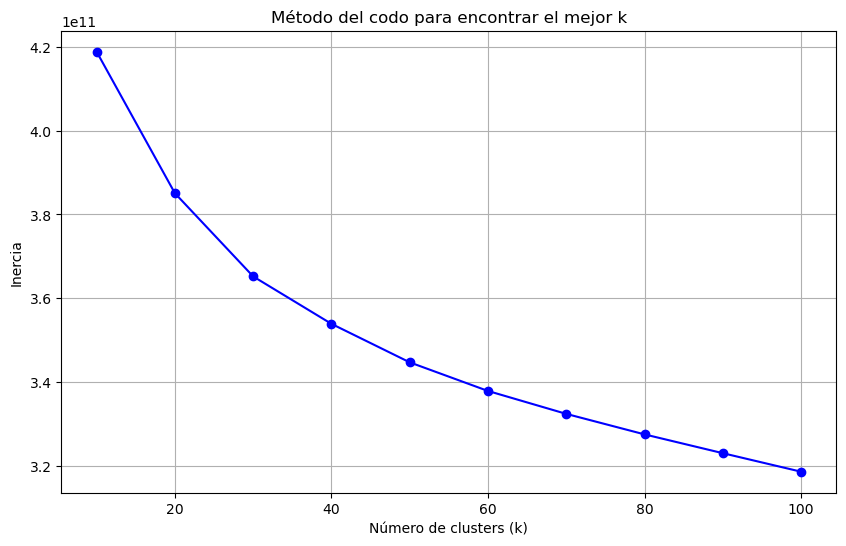

El mejor valor de k según el método del codo es: 100


In [464]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

def encontrar_mejor_k(descriptores_totales, rango_k, batch_size=1024):
    
    all_descriptors=np.vstack(descriptores_totales)
    inercias=[]
    
    for k in rango_k:
        
        print(f"Processant amb k={k}")
        mini_batch=MiniBatchKMeans(n_clusters=k,batch_size=batch_size,random_state=33)
        mini_batch.fit(all_descriptors)
        inercias.append(mini_batch.inertia_)
        
    plt.figure(figsize=(10, 6))    
    plt.plot(rango_k, inercias, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inèrcia')
    plt.title('Mètodo Elbow per trobar la millor k')
    plt.grid(True)
    plt.show()
    
    return rango_k[np.argmin(np.gradient(np.gradient(inercias)))], inercias

data = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/descriptores_sift.npz', allow_pickle=True)
descriptores = [data[key] for key in data.files]


rango_k = list(range(10, 101, 10)) 

mejor_k, inertias = encontrar_mejor_k(descriptores, rango_k)

print(f"El millor valor de k segons el mètodo de Elbow és: {mejor_k}")

* Tanmateix, com el procés pot ser molt costós computacionalment quan treballem amb una gran quantitat de dades, optem per utilitzar **MiniBatchKMeans**. Aquest mètode és una variant més eficient de K-means que processa petites submostres dels dades en cada iteració, el que accelera el procés de convergència.

* A més, aprofitarem la **paral·lelització de la CPU** utilitzant el paràmetre `n_jobs=-1` per distribuir la càrrega de treball entre tots els nuclis disponibles, augmentant així l'eficiència del càlcul.

* De mateixa manera que amb els descriptors, també els guardem a l'ordinador per no haver de repetir l'execucció.

In [397]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def crear_visual_words_minibatch(descriptores_totales, k, batch_size=1024, n_jobs=-1):

    all_descriptors = np.vstack(descriptores_totales)


    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=33)
    mb_kmeans.fit(all_descriptors)

    vocabulary = mb_kmeans.cluster_centers_
    print(f"Vocabulario visual creat amb {k} paraules.")

    return vocabulary, mb_kmeans

data = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/descriptores_sift.npz', allow_pickle=True)
descriptores = [data[key] for key in data.files]


k = 100  
vocabulary, mb_kmeans_model = crear_visual_words_minibatch(descriptores, k, n_jobs=-1)

np.save('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/vocabulary.npy', vocabulary)


Entrenando MiniBatchKMeans para crear Visual Words...


C:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Vocabulario visual creado con 100 palabras.


### Histogrames

* Un cop hem obtingut els descriptors i creat els Visual Words mitjançant l'algoritme de clustering K-means (o MiniBatchKMeans), el següent pas és generar els **histogrames** per a cada frame. Els histogrames són essencials per representar la distribució dels **Visual Words** dins de cada imatge o frame. Això ens permet crear una representació numèrica dels frames, on cada histograma reflecteix la freqüència d'aparició de cada **Visual Word** dins del conjunt de descriptors d'un frame concret.

* Finalment, guardarem aquests histogrames al sistema per evitar la re-execució del procés, millorant l'eficiència computacional en futures iteracions del projecte.



In [399]:
import numpy as np

def generar_histograma_visual_y_filtrar(descriptores_totales, vocabulary, rutas_imagenes):
    num_clusters = vocabulary.shape[0]
    histograms = []
    rutas_validas = []

    for descriptores, ruta in zip(descriptores_totales, rutas_imagenes):
        if descriptores is not None: 
            histograma = np.zeros(num_clusters)
            for descriptor in descriptores:
                idx = np.argmin(np.linalg.norm(vocabulary - descriptor, axis=1))
                histograma[idx] += 1

            histograma /= np.sum(histograma) 
            histograms.append(histograma)
            rutas_validas.append(ruta)
    
    return np.array(histograms), rutas_validas

data = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/descriptores_sift.npz', allow_pickle=True)
descriptores = [data[key] for key in data.files]

vocabulary = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/vocabulary.npy')

rutas_imagenes = df_reducido['ruta_imatge'].tolist()
histograms, rutas_validas = generar_histograma_visual_y_filtrar(descriptores, vocabulary, rutas_imagenes)

np.save('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/histograms.npy', histograms)
np.save('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/rutas_validas.npy', rutas_validas)



print(f"Histogrames generats: {histograms.shape}")
print(f"Imatges vàlides: {len(rutas_validas)}")


Histogramas generados: (2989, 100)
Imágenes válidas: 2989


# 4. Cerca d'Hiperparàmetres

Per optimitzar els nostres models de classificació, utilitzem **GridSearchCV**, una tècnica que busca de manera exhaustiva els millors valors per als hiperparàmetres. 

En el nostre cas, hem provat els següents models:
- **SVM (Support Vector Machine)**: Amb kernels `linear` i `rbf` i ajustant el paràmetre `C` i `gamma`.
- **Random Forest**: Optimitzant el nombre d'`estimadors`, la `profunditat màxima` i les `màximes mostres de divisió`.
- **KNN (K-Nearest Neighbors)**: Ajustant el nombre de veïns `n_neighbors`, el pes (`weights`) i el tipus de norma (`p`).
- **Logistic Regression**: Provant diferents valors de `C` i el `solver` per a l'optimització.










In [393]:
histograms = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/histograms.npy')
rutas_validas = np.load('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/rutas_validas.npy')

df_validado = df_reducido[df_reducido['ruta_imatge'].isin(rutas_validas)]
    
labels = df_validado['pelicula'].tolist() 

In [402]:
from sklearn.model_selection import GridSearchCV, train_test_split,StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

histograms_normalized = histograms / np.linalg.norm(histograms, axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(histograms_normalized, labels, test_size=0.2, random_state=33)

parametros = {
    'SVM': {
        'kernel': ['linear', 'rbf'], 
        'C': [0.01, 0.1, 1, 10, 100], 
        'gamma': ['scale', 'auto']     
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200], 
        'max_depth': [None, 10, 20], 
        'min_samples_split': [2, 5, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11], 
        'weights': ['uniform', 'distance'],
        'p': [1, 2] 
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100], 
        'solver': ['lbfgs', 'saga'],
        'penalty': ['l2'] 
    }
}

modelos = {
    'SVM': SVC(random_state=33),
    'Random Forest': RandomForestClassifier(random_state=33),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=33, max_iter=1000)
}

for nombre, modelo in modelos.items():
    print(f"\nOptimitzant hiperparàmetres per: {nombre}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
    grid = GridSearchCV(estimator=modelo, param_grid=parametros[nombre], cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"Millors hiperparàmetres per {nombre}: {grid.best_params_}")


Optimizando hiperparámetros para: SVM
Mejores hiperparámetros para SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Optimizando hiperparámetros para: Random Forest
Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Optimizando hiperparámetros para: KNN


C:\Users\david\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan 0.90254802 0.86239551 0.87996087        nan 0.88330902
 0.82141316 0.85152558        nan 0.8465099  0.78251937 0.82266839
        nan 0.82559988 0.74028005 0.79966545        nan 0.8030136
 0.70514758 0.77415466]
  warnings.warn(


Mejores hiperparámetros para KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Optimizando hiperparámetros para: Logistic Regression
Mejores hiperparámetros para Logistic Regression: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


# 5. Model Selection

* Un cop hem obtingut els millors hiperparàmetres per a cada model mitjançant la cerca d'hiperparàmetres, hem avaluat el rendiment dels models amb les configuracions òptimes.

* Per a cada model (mencionats anteriorment), hem calculat la precisió tant en el conjunt d'entrenament com en el conjunt de test, així com una avaluació més detallada mitjançant el **classification_report**, que ens proporciona mètriques com la precisió, recall i f1-score.








In [410]:
modelos={
    "SVM":SVC(C=10, kernel='rbf',gamma="scale",random_state=33),
    "Random Forest":RandomForestClassifier(max_depth=20,min_samples_split=2,n_estimators=200,random_state=33),
    "Knn":KNeighborsClassifier(n_neighbors=3,p=1,weights='distance'),
    "Logistic Regression":LogisticRegression(C=100,solver='lbfgs',penalty='l2',random_state=33,max_iter=1000)
}
for nombre,modelo in modelos.items():
    print(f"Evaluant el model {nombre}")
    modelo.fit(X_train,y_train)
    
    y_pred=modelo.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    
    y_train_pred=modelo.predict(X_train)
    train_accuracy=accuracy_score(y_train,y_train_pred)

    print(f"Accuracy del model train {nombre}: {train_accuracy:.2f}")
    print(f"Accuracy del model test {nombre}: {accuracy:.2f}")
    print(f"Classification report per {nombre}:\n")
    print(classification_report(y_test, y_pred))

Evaluando el modelo SVM
Accuracy del modelo train SVM: 0.99
Accuracy del modelo test SVM: 0.93
Reporte de clasificación para SVM:

                  precision    recall  f1-score   support

  APOCALYPSE_NOW       0.92      0.94      0.93        63
          BARBIE       0.95      0.94      0.95        67
      CASABLANCA       0.89      0.95      0.92        44
      GOODFELLAS       0.88      0.92      0.90        48
      LA_LA_LAND       0.86      0.80      0.83        64
        SCARFACE       0.97      0.97      0.97        64
   THE_GODFATHER       0.94      0.93      0.93        69
THE_GODFATHER_II       0.91      0.93      0.92        54
    THE_SHINNING       0.95      0.94      0.95        65
        TORRENTE       0.98      1.00      0.99        60

        accuracy                           0.93       598
       macro avg       0.93      0.93      0.93       598
    weighted avg       0.93      0.93      0.93       598

Evaluando el modelo Random Forest
Accuracy del modelo 

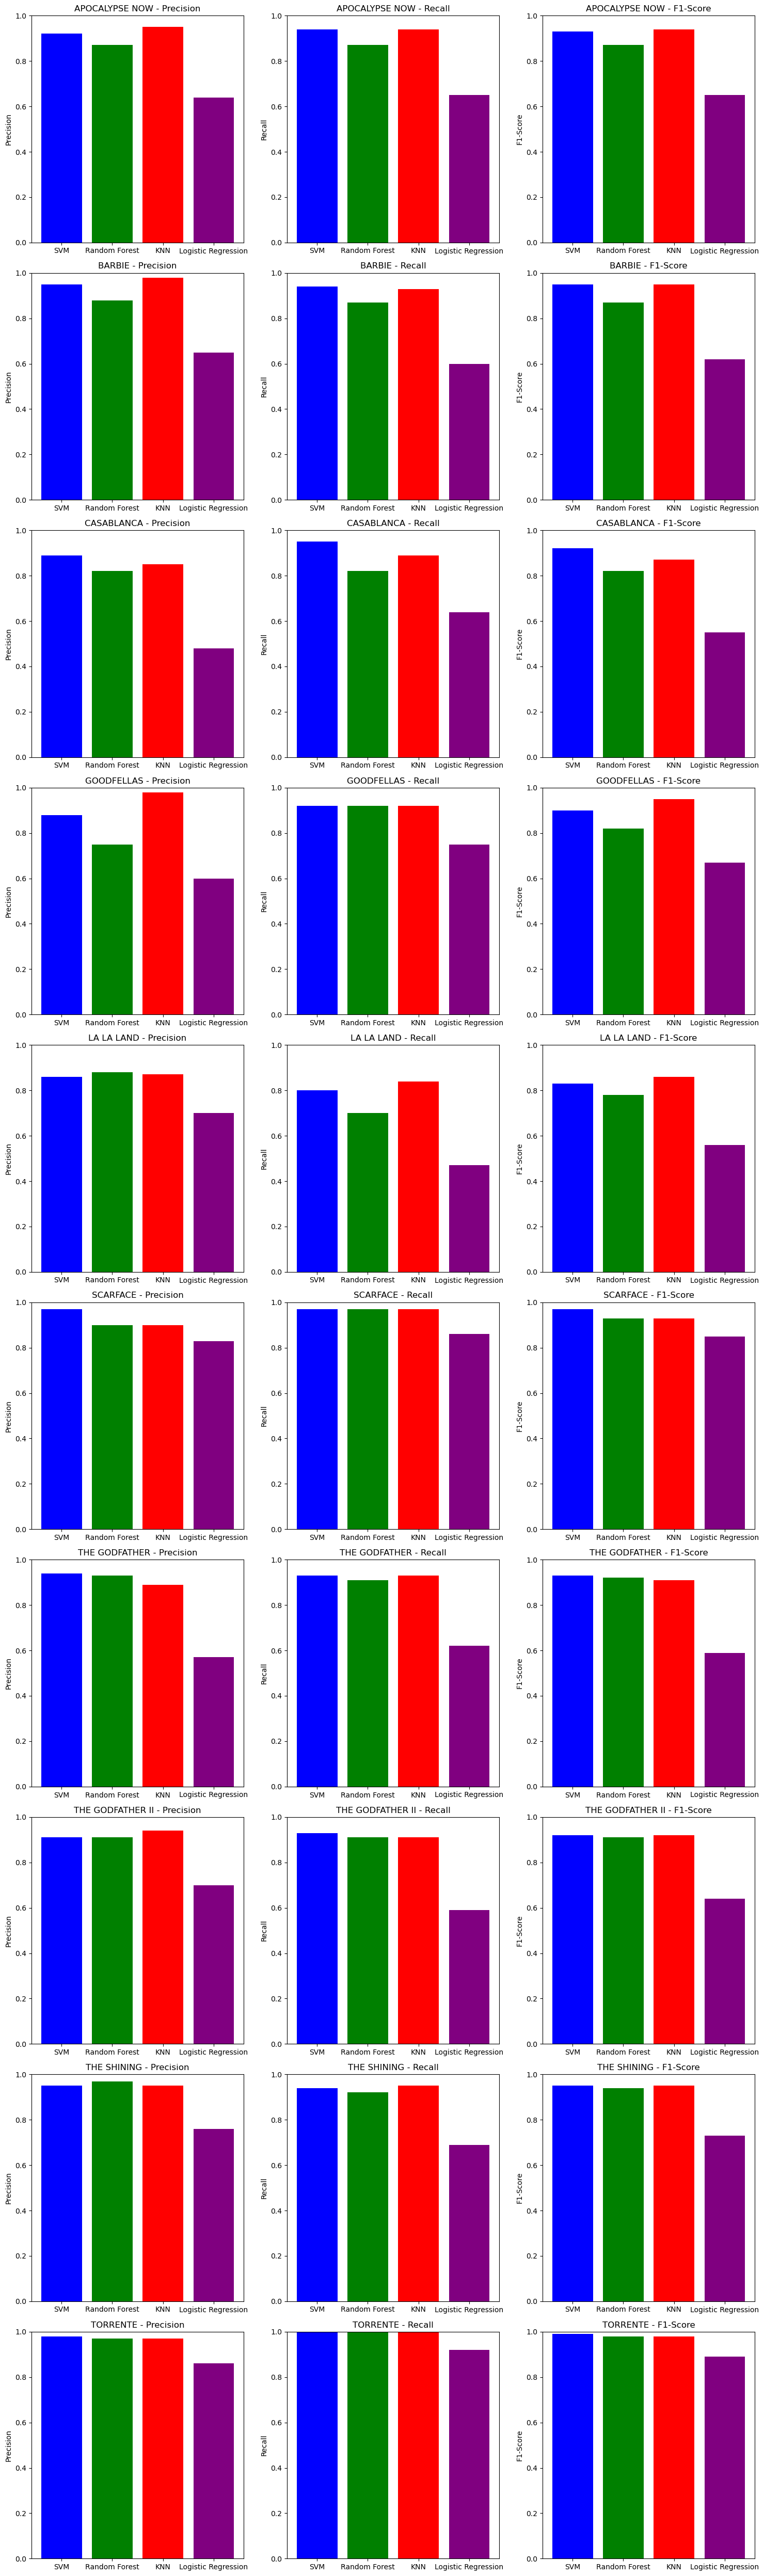

In [434]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'Clase': ['APOCALYPSE NOW', 'BARBIE', 'CASABLANCA', 'GOODFELLAS','LA LA LAND','SCARFACE','THE GODFATHER','THE GODFATHER II','THE SHINING','TORRENTE'],
    'SVM Precision': [0.92, 0.95, 0.89, 0.88,0.86,0.97,0.94,0.91,0.95,0.98],
    'SVM Recall': [0.94, 0.94, 0.95, 0.92,0.8,0.97,0.93,0.93,0.94,1.],
    'SVM F1-Score': [0.93, 0.95, 0.92, 0.9,0.83,0.97,0.93,0.92,0.95,0.99],
    
    'Random Forest Precision': [0.87, 0.88, 0.82, 0.75,0.88,0.9,0.93,0.91,0.97,0.97],
    'Random Forest Recall': [0.87,0.87,0.82,0.92,0.7,0.97,0.91,0.91,0.92,1.],
    'Random Forest F1-Score': [0.87,0.87,0.82,0.82,0.78,0.93,0.92,0.91,0.94,0.98],
    
    'KNN Precision': [0.95,0.98,0.85,0.98,0.87,0.9,0.89,0.94,0.95,0.97],
    'KNN Recall': [0.94,0.93,0.89,0.92,0.84,0.97,0.93,0.91,0.95,1.],
    'KNN F1-Score': [0.94,0.95,0.87,0.95,0.86,0.93,0.91,0.92,0.95,0.98],
    
    'Logistic Regression Precision': [0.64,0.65,0.48,0.6,0.7,0.83,0.57,0.7,0.76,0.86],
    'Logistic Regression Recall': [0.65,0.6,0.64,0.75,0.47,0.86,0.62,0.59,0.69,0.92],
    'Logistic Regression F1-Score': [0.65,0.62,0.55,0.67,0.56,0.85,0.59,0.64,0.73,0.89]
}


clases = metrics['Clase']
metrics_labels = ['Precision', 'Recall', 'F1-Score']
modelos = ['SVM', 'Random Forest', 'KNN', 'Logistic Regression']


fig, axes = plt.subplots(len(clases), 3, figsize=(15, len(clases) * 5))

for i, pelicula in enumerate(clases):

    precision = [metrics[f'{modelo} Precision'][i] for modelo in modelos]
    recall = [metrics[f'{modelo} Recall'][i] for modelo in modelos]
    f1_score = [metrics[f'{modelo} F1-Score'][i] for modelo in modelos]

    axes[i, 0].bar(modelos, precision, color=['blue', 'green', 'red', 'purple'])
    axes[i, 0].set_title(f'{pelicula} - Precision')
    axes[i, 0].set_ylim(0, 1)
    axes[i, 0].set_ylabel('Precision')

    axes[i, 1].bar(modelos, recall, color=['blue', 'green', 'red', 'purple'])
    axes[i, 1].set_title(f'{pelicula} - Recall')
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_ylabel('Recall')

    axes[i, 2].bar(modelos, f1_score, color=['blue', 'green', 'red', 'purple'])
    axes[i, 2].set_title(f'{pelicula} - F1-Score')
    axes[i, 2].set_ylim(0, 1)
    axes[i, 2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_15068\1898278374.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(clases, rotation=45, ha='right')


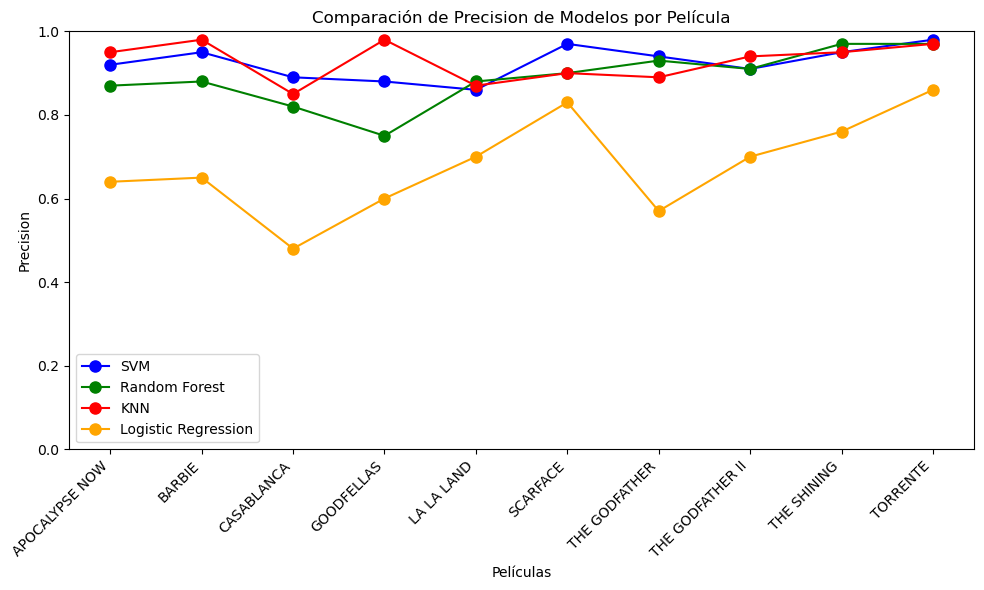

In [448]:
import matplotlib.pyplot as plt
import numpy as np

metrics_precision = {
    'Clase': ['APOCALYPSE NOW', 'BARBIE', 'CASABLANCA', 'GOODFELLAS','LA LA LAND','SCARFACE','THE GODFATHER','THE GODFATHER II','THE SHINING','TORRENTE'],
    'SVM Precision': [0.92, 0.95, 0.89, 0.88,0.86,0.97,0.94,0.91,0.95,0.98],
    'Random Forest Precision': [0.87, 0.88, 0.82, 0.75,0.88,0.9,0.93,0.91,0.97,0.97],
    'KNN Precision': [0.95,0.98,0.85,0.98,0.87,0.9,0.89,0.94,0.95,0.97],
    'Logistic Regression Precision': [0.64,0.65,0.48,0.6,0.7,0.83,0.57,0.7,0.76,0.86],
}
metrics_recall = {
    'Clase': ['APOCALYPSE NOW', 'BARBIE', 'CASABLANCA', 'GOODFELLAS','LA LA LAND','SCARFACE','THE GODFATHER','THE GODFATHER II','THE SHINING','TORRENTE'],
    'SVM Recall': [0.94, 0.94, 0.95, 0.92,0.8,0.97,0.93,0.93,0.94,1.],
    'Random Forest Recall': [0.87,0.87,0.82,0.92,0.7,0.97,0.91,0.91,0.92,1.],
    'KNN Recall': [0.94,0.93,0.89,0.92,0.84,0.97,0.93,0.91,0.95,1.],
    'Logistic Regression Recall': [0.65,0.6,0.64,0.75,0.47,0.86,0.62,0.59,0.69,0.92],
}

metrics_f1 = {
    'Clase': ['APOCALYPSE NOW', 'BARBIE', 'CASABLANCA', 'GOODFELLAS','LA LA LAND','SCARFACE','THE GODFATHER','THE GODFATHER II','THE SHINING','TORRENTE'],
    'SVM F1-Score': [0.93, 0.95, 0.92, 0.9,0.83,0.97,0.93,0.92,0.95,0.99],
    'Random Forest F1-Score': [0.87,0.87,0.82,0.82,0.78,0.93,0.92,0.91,0.94,0.98],
    'KNN F1-Score': [0.94,0.95,0.87,0.95,0.86,0.93,0.91,0.92,0.95,0.98],
    'Logistic Regression F1-Score': [0.65,0.62,0.55,0.67,0.56,0.85,0.59,0.64,0.73,0.89]
}

clases = metrics_precision['Clase']
modelos = ['SVM', 'Random Forest', 'KNN', 'Logistic Regression']

svm_precision = metrics_precision['SVM Precision']
rf_precision = metrics_precision['Random Forest Precision']
knn_precision = metrics_precision['KNN Precision']
logreg_precision = metrics_precision['Logistic Regression Precision']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(clases, svm_precision, marker='o', label='SVM', color='blue', linestyle='-', markersize=8)
ax.plot(clases, rf_precision, marker='o', label='Random Forest', color='green', linestyle='-', markersize=8)
ax.plot(clases, knn_precision, marker='o', label='KNN', color='red', linestyle='-', markersize=8)
ax.plot(clases, logreg_precision, marker='o', label='Logistic Regression', color='orange', linestyle='-', markersize=8)

ax.set_xlabel('Pel·lícules')
ax.set_ylabel('Precision')
ax.set_title('Comparació de Precision de Models per Pel·lícules')
ax.set_xticklabels(clases, rotation=45, ha='right')
ax.set_ylim(0, 1)


ax.legend()

plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_15068\3495860069.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(clases, rotation=45, ha='right')


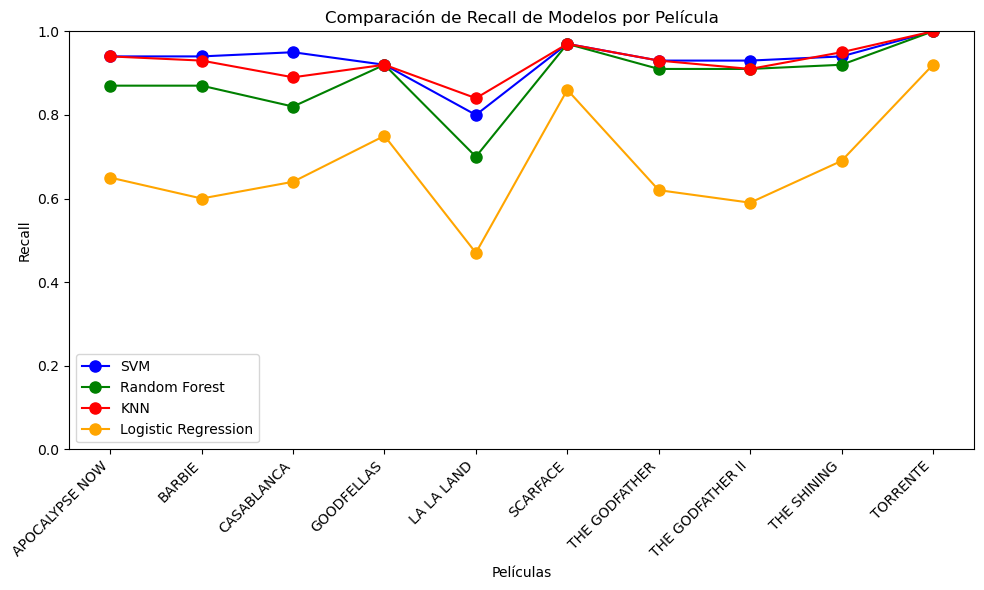

In [449]:
clases = metrics_recall['Clase']

svm_recall = metrics_recall['SVM Recall']
rf_recall = metrics_recall['Random Forest Recall']
knn_recall = metrics_recall['KNN Recall']
logreg_recall = metrics_recall['Logistic Regression Recall']

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(clases, svm_recall, marker='o', label='SVM', color='blue', linestyle='-', markersize=8)
ax.plot(clases, rf_recall, marker='o', label='Random Forest', color='green', linestyle='-', markersize=8)
ax.plot(clases, knn_recall, marker='o', label='KNN', color='red', linestyle='-', markersize=8)
ax.plot(clases, logreg_recall, marker='o', label='Logistic Regression', color='orange', linestyle='-', markersize=8)

ax.set_xlabel('Pel·lícules')
ax.set_ylabel('Recall')
ax.set_title('Comparació de Recall de Models per Pel·lícules')
ax.set_xticklabels(clases, rotation=45, ha='right')
ax.set_ylim(0, 1)


ax.legend()

plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_15068\966338848.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(clases, rotation=45, ha='right')


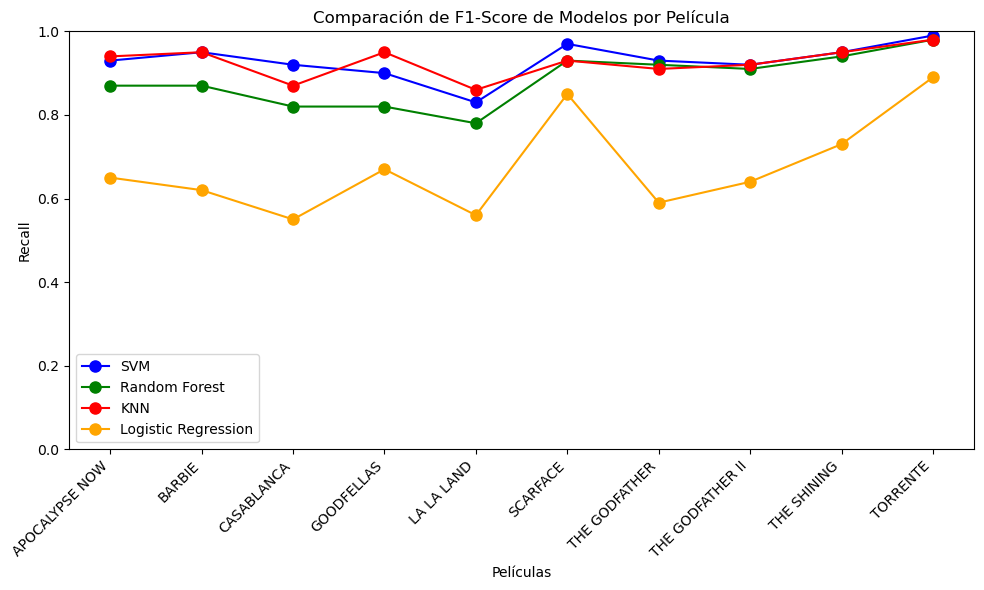

In [453]:
clases = metrics_f1['Clase']

svm_f1 = metrics_f1['SVM F1-Score']
rf_f1 = metrics_f1['Random Forest F1-Score']
knn_f1 = metrics_f1['KNN F1-Score']
logreg_f1 = metrics_f1['Logistic Regression F1-Score']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(clases, svm_f1, marker='o', label='SVM', color='blue', linestyle='-', markersize=8)
ax.plot(clases, rf_f1, marker='o', label='Random Forest', color='green', linestyle='-', markersize=8)
ax.plot(clases, knn_f1, marker='o', label='KNN', color='red', linestyle='-', markersize=8)
ax.plot(clases, logreg_f1, marker='o', label='Logistic Regression', color='orange', linestyle='-', markersize=8)

ax.set_xlabel('Pel·lícules')
ax.set_ylabel('Recall')
ax.set_title('Comparació de F1-score de Models per Pel·lícules')
ax.set_xticklabels(clases, rotation=45, ha='right')
ax.set_ylim(0, 1)

ax.legend()

plt.tight_layout()
plt.show()


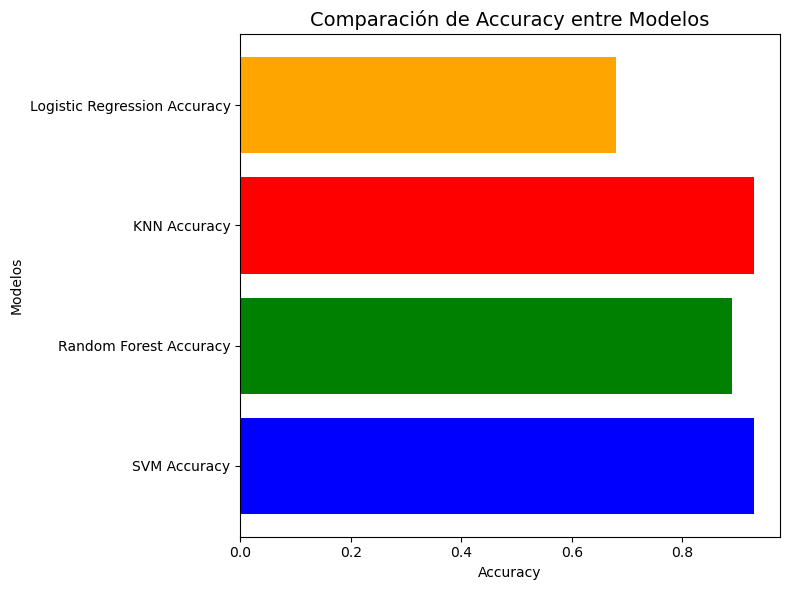

In [462]:
import matplotlib.pyplot as plt
accuracy_metrics = {
    'SVM Accuracy': 0.93,
    'Random Forest Accuracy': 0.89,
    'KNN Accuracy': 0.93,
    'Logistic Regression Accuracy': 0.68
}


plt.figure(figsize=(8, 6))
plt.barh(list(accuracy_metrics.keys()), list(accuracy_metrics.values()), color=['blue', 'green', 'red', 'orange'])


plt.title('Comparació de Accuracy entre Models', fontsize=14)
plt.xlabel('Accuracy')
plt.ylabel('Models')

plt.tight_layout()
plt.show()


### Resum de resultats dels models i mètriques

En aquest experiment, hem avaluat quatre models diferents per a la classificació de pel·lícules: **SVM**, **Random Forest**, **KNN** i **Logistic Regression**. A continuació mostrem els resultats més destacats per a cada model:

* **SVM**: Té una **precisió de test** de 93% i un **f1-score** mitjà de 0.93 per a totes les classes. El model ha mostrat un rendiment alt, amb una gran capacitat per generalitzar, com ho demostra la seva precisió i recall bastant equilibrats a les diferents classes.

* **Random Forest**: Tot i que ha aconseguit un **accuracy de test** de 89%, el model ha mostrat una menor precisió en algunes classes (per exemple, en *LA_LA_LAND* amb 0.78 de f1-score). La seva **precisió de train** és del 100%, indicant que el model pot estar cometent un lleu overfitting.

* **KNN**: Amb un **accuracy de test** de 93% i una **f1-score** mitjana de 0.93, el model KNN ha mostrat resultats molt similars als de l'SVM, amb una precisió molt bona en la majoria de les classes.

* **Logistic Regression**: Aquest model ha obtingut una **precisió de test** de 68%, amb **f1-scores** inferiors a 0.7 per a diverses classes, mostrant un rendiment considerablement més baix en comparació amb els altres models.

### Conclusió

* **Millor model**: Tant el SVM com el KNN poden ser considerats com els millors models per a aquesta tasca de classificació. Tots dos presenten un accuracy de test de 93% i f1-scores molt similars (SVM: 0.93, KNN: 0.93), ambdós sent models molt sòlids per a la classificació de les pel·lícules.
  
* **Millor mètrica**: El f1-score és la mètrica més equilibrada i fiable per avaluar el rendiment dels models en un conjunt de dades balancejat. Això és perquè el f1-score té en compte tant la precisió com el recall, fent-lo ideal per comparar models en tasques de classificació.

